# Data preprocessor

In [1]:
import os
import glob
import cv2
import datetime

import numpy as np
import pandas as pd

from os import mkdir

def load_img_paths(target):
    '''
    Retrieve the full path of all images in the dataset
    '''
    return glob.glob(target + '/*.tif')

output_dir = '../data/hnet_training_%s' % datetime.date.today().isoformat()
try: 
    mkdir(output_dir)
except FileExistsError:
    print('directory already exists')

data_dir = r'../data'
original_data_dir = data_dir + ('/learning')
all_files = load_img_paths(original_data_dir)
np.random.seed(1234)
np.random.shuffle(all_files)
all_files[:5]

['../data/learning\\Tp26_Y003_X006_040.tif',
 '../data/learning\\Tp26_Y003_X009_040.tif',
 '../data/learning\\Tp26_Y003_X003_040.tif',
 '../data/learning\\Tp26_Y005_X012_040.tif',
 '../data/learning\\Tp26_Y006_X014_040.tif']

In [2]:
from numpy.random import randint

def aspect_resize(newsize, shape):
    '''
    Given an integer and a shape, return a tuple with the longest side of the shape = newsize
    '''
    m = np.argmax(shape)
    if m == 0:
        return (newsize, int(shape[0] / (shape[1] / newsize)))
    return (int(shape[1] / (shape[0] / newsize)), newsize)

def alter_pt(pt, r):
    r1,r2 = randint(-r,r+1,2)
    return (pt[0] + r1, pt[1] + r2)

def create_patches(im, size, r):
    '''
    Create pairs of patches from an image
    '''
    while True:
        # generate four random points, r to size-r so as to not go over the edge
        x = randint(r, im.shape[0]-size-r)
        y = randint(r, im.shape[1]-size-r)
        tl = (x,y)
        tr = (tl[0], tl[1]+size)
        br = (tl[0]+size, tl[1]+size)
        bl = (tl[0]+size, tl[1])
        A = im[y:y+size,x:x+size] # this is our 'reference' image
        # alter points randomly by rho
        tl2 = alter_pt(tl, r)
        tr2 = alter_pt(tr, r)
        br2 = alter_pt(br, r)
        bl2 = alter_pt(bl, r)
        perturbed = np.float32([tl2, tr2, br2, bl2])
        # transform
        H = cv2.getPerspectiveTransform(np.float32([tl, tr, br, bl]), perturbed)
        Hab = np.linalg.inv(H) 
        # warp image
        full_warped = cv2.warpPerspective(im, Hab, im.shape, flags=cv2.INTER_CUBIC, \
                                          borderMode=cv2.BORDER_CONSTANT, borderValue=int(im.mean()))
        B = full_warped[y:y+size,x:x+size]
        
        # make sure the images actually have contents.
        thresh = 1600
        _, binary_a = cv2.threshold(A,127,1,cv2.THRESH_BINARY_INV)
        _, binary_b = cv2.threshold(B,127,1,cv2.THRESH_BINARY_INV)
        if A.shape == B.shape and binary_a.sum() > thresh and binary_b.sum() > thresh:
            return A, B, np.subtract(perturbed, [tl, tr, br, bl])


In [3]:
from matplotlib import pyplot as plt

new_size = 672 # 1/2 original, same as paper
patch_size = 224 # 1/3rd image, same as paper
rho = 56 # 1/3rd patch size, as opposed to 1/3rd which led to bad edge effects

fname = '../data/learning/Tp26_Y000_X001_040.tif'
im = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
im = cv2.resize(im, aspect_resize(new_size, im.shape), interpolation=cv2.INTER_CUBIC)
print(fname, im.shape)
a,b,h = create_patches(im, patch_size, rho)

fig, (ref, mov) = plt.subplots(1, 2, figsize=(8, 4))
print(h)
ref.imshow(a, cmap='gray')
ref.get_xaxis().set_visible(False)
ref.get_yaxis().set_visible(False)

mov.imshow(b, cmap='gray')
mov.get_xaxis().set_visible(False)
mov.get_yaxis().set_visible(False)

plt.show()

../data/learning/Tp26_Y000_X001_040.tif (672, 882)
[[-39. -56.]
 [ 11. -19.]
 [ 26. -26.]
 [-30.   4.]]


<Figure size 800x400 with 2 Axes>

## Generate patches

- `new_size` - recommended that it be small enough so that there is content in the image 320 is what the paper uses. 
- `patch_size` - size of patch, here it's 128, so that horizontally if covers about a third of the image.
- `rho` - we can think of this as overlap, it's the theshold on perturbation in the transform.
- `patches_per_image` - size of inner loop, should probably be greater than 100

> We then generate 500,000 pairs of image patches sized 128x128 related by a homography

This is my "[We're going to need a bigger boat](https://www.youtube.com/watch?v=2I91DJZKRxs)" moment.

In [4]:
df = pd.DataFrame(columns=['fname', 'h'])
new_size = 672 # 1/2 original, same as paper
patch_size = 224 # 1/3rd image, same as paper
rho = 56 # 1/4th patch size, as opposed to 1/3rd which led to bad edge effects

output_size = (112, 112)
ratio = output_size[0] / patch_size

'''
we have 8*15 = 120 images right now...
100 = 1200
500 = 60,000
750 = 90,000
1000 = 120,000
4167 = 500,040
'''

patches_per_image = 500

for f in all_files:
    fname,ext = os.path.basename(f).split('.')
    im = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    im = cv2.resize(im, aspect_resize(new_size, im.shape))
    for p in range(0, patches_per_image):
        A,B,Hab = create_patches(im, patch_size, rho)
        fbase = '%s_%s' % (fname, str(p).rjust(4, '0'))
        A_name = '%s_A.%s' % (fbase, ext)
        B_name = '%s_B.%s' % (fbase, ext)
        cv2.imwrite(os.path.join(output_dir, A_name), cv2.resize(A, output_size, interpolation=cv2.INTER_NEAREST))
        cv2.imwrite(os.path.join(output_dir, B_name), cv2.resize(B, output_size, interpolation=cv2.INTER_NEAREST))
        mod_Hab = Hab * ratio
        hab_1d = ','.join(list(map(lambda x: str(float(x)), mod_Hab.reshape(1,8)[0].tolist())))
        df = df.append({'fname':fbase, 'h':hab_1d}, ignore_index=True)

df.to_csv(os.path.join(output_dir, 'homographies.tsv'),sep='\t')

KeyboardInterrupt: 

In [ ]:
df.head()

In [305]:
len(df)

60000

## Constant rho

Generate patches where rho is related to overlap. An additional difference is that displacement is constant for each corner. Expected values from a network are in the format (+y,+x).

In [4]:
def alter_pt_constant(pt,x,y):
    return (pt[0] + x, pt[1] + y)

def create_rigid_patches(im, size, r):
    '''
    Create pairs of patches from an image
    '''
    while True:
        # generate four random points, r to size-r so as to not go over the edge
        x = randint(0, im.shape[1]-size)
        y = randint(0, im.shape[0]-size)
        
        tl = (x,y)
        tr = (tl[0], tl[1]+size)
        br = (tl[0]+size, tl[1]+size)
        bl = (tl[0]+size, tl[1])
        A = im[y:y+size,x:x+size] # this is our 'reference' image
        
        # generate x,y displacements
        x_dis, y_dis = randint(-r, r+1, 2)
        
        # alter points randomly by rho
        tl2 = alter_pt_constant(tl, x_dis, y_dis)
        tr2 = alter_pt_constant(tr, x_dis, y_dis)
        br2 = alter_pt_constant(br, x_dis, y_dis)
        bl2 = alter_pt_constant(bl, x_dis, y_dis)
        perturbed = np.float32([tl2, tr2, br2, bl2])
        # transform
        H = cv2.getPerspectiveTransform(np.float32([tl, tr, br, bl]), perturbed)
        Hab = np.linalg.inv(H)
        # warp image
        
        full_warped = cv2.warpPerspective(im, Hab, im.shape, flags=cv2.INTER_NEAREST, \
                                          borderMode=cv2.BORDER_CONSTANT, borderValue=int(im.mean()))
        B = full_warped[y:y+size,x:x+size]
        
        # make sure the images actually have contents.
        thresh = 2200
        _, binary_a = cv2.threshold(A,127,1,cv2.THRESH_BINARY_INV)
        _, binary_b = cv2.threshold(B,127,1,cv2.THRESH_BINARY_INV)
        if A.shape == B.shape and binary_a.sum() > thresh and binary_b.sum() > thresh:
            return A, B, [x_dis, y_dis]

../data/learning/Tp26_Y000_X001_040.tif (672, 882) 336 134.4
[9, -106]


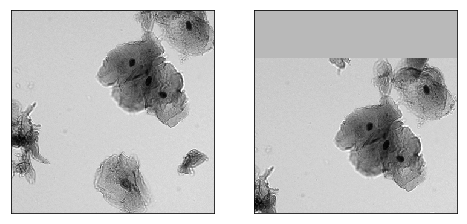

0.97 x, 0.68 y


In [5]:
new_size = 672 # 1/2 original, same as paper
patch_size = new_size // 2 # 1/2 image
rho = patch_size * 4/10 # 2/5th potential distortion = 60% minimum overlap

fname = '../data/learning/Tp26_Y000_X001_040.tif'
im = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
im = cv2.resize(im, aspect_resize(new_size, im.shape), interpolation=cv2.INTER_NEAREST)
print(fname, im.shape, patch_size, rho)
a,b,h = create_rigid_patches(im, patch_size, rho)

fig, (ref, mov) = plt.subplots(1, 2, figsize=(8, 4))
print(h)
ref.imshow(a, cmap='gray')
ref.get_xaxis().set_visible(False)
ref.get_yaxis().set_visible(False)

mov.imshow(b, cmap='gray')
mov.get_xaxis().set_visible(False)
mov.get_yaxis().set_visible(False)

plt.show()
print('%.02f x, %0.02f y' % ((patch_size-abs(h[0]))/patch_size, (patch_size-abs(h[1]))/patch_size))

13976 12708


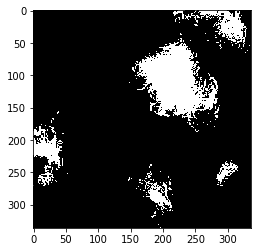

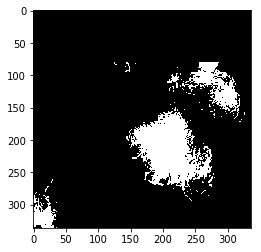

In [6]:
_,a_t = cv2.threshold(a,127,1,cv2.THRESH_BINARY_INV)
_,b_t = cv2.threshold(b,127,1,cv2.THRESH_BINARY_INV)
print(a_t.sum(), b_t.sum())
plt.imshow(a_t, cmap='gray')
plt.show()
plt.imshow(b_t, cmap='gray')
plt.show()

In [7]:
#minimum overlap
(patch_size - rho) / patch_size

0.6

In [468]:
df = pd.DataFrame(columns=['fname', 'h'])
new_size = 672 # 1/2 original, same as paper
patch_size = new_size // 2 # 1/2 image
rho = patch_size * 4/10 # 2/5th potential distortion = 60% minimum overlap

output_size = (128, 128)
ratio = output_size[0] / patch_size

'''
we have 8*15 = 120 images right now...
100 = 1200
500 = 60,000
750 = 90,000
1000 = 120,000
4167 = 500,040
'''

output_dir = '../data/hnet_rigid_training_128%s' % datetime.date.today().isoformat()
try: 
    mkdir(output_dir)
except FileExistsError:
    print('directory already exists')

patches_per_image = 500

for f in all_files:
    fname,ext = os.path.basename(f).split('.')
    im = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    im = cv2.resize(im, aspect_resize(new_size, im.shape))
    for p in range(0, patches_per_image):
        A,B,Hab = create_rigid_patches(im, patch_size, rho)
        fbase = '%s_%s' % (fname, str(p).rjust(4, '0'))
        A_name = '%s_A.%s' % (fbase, ext)
        B_name = '%s_B.%s' % (fbase, ext)
        cv2.imwrite(os.path.join(output_dir, A_name), cv2.resize(A, output_size, interpolation=cv2.INTER_NEAREST))
        cv2.imwrite(os.path.join(output_dir, B_name), cv2.resize(B, output_size, interpolation=cv2.INTER_NEAREST))
        mod_Hab = np.array(Hab) * ratio
        hab_1d = ','.join(list(map(lambda x: '%0.03f' % float(x), mod_Hab.reshape(1,2)[0].tolist())))
        df = df.append({'fname':fbase, 'h':hab_1d}, ignore_index=True)

df.to_csv(os.path.join(output_dir, 'homographies.tsv'),sep='\t')

In [8]:
df.head()

NameError: name 'df' is not defined

## Variable window size

In [27]:
def alter_pt_constant(pt,x,y):
    return (pt[0] + x, pt[1] + y)

def create_multiscale_rigid_patches(im, w_min, w_max, final_size, max_overlap):
    '''
    Create pairs of patches from an image
    '''
    size = randint(w_min, w_max)
    r = int(max_overlap * size)
    im = np.pad(im, int(2*r), mode='constant', constant_values=np.median(im))
    while True:
        # generate two random points, r to size-r so as to not go over the edge
        x = randint(2*r, im.shape[1]-size-2*r)
        y = randint(2*r, im.shape[0]-size-2*r)

        A = im[y:y+size,x:x+size] # this is our 'reference' image
        A = cv2.resize(A, final_size, interpolation=cv2.INTER_CUBIC)
        
        # generate x,y displacements
        x_dis, y_dis = randint(-r, r+1, 2)
        
        B = im[y+y_dis:y+size+y_dis, 
               x+x_dis:x+size+x_dis]
        B = cv2.resize(B, final_size, interpolation=cv2.INTER_CUBIC)
        
        # make sure the images actually have contents.
        thresh = 750
        _, binary_a = cv2.threshold(A,127,1,cv2.THRESH_BINARY_INV)
        _, binary_b = cv2.threshold(B,127,1,cv2.THRESH_BINARY_INV)
        if A.shape == B.shape and binary_a.sum() > thresh and binary_b.sum() > thresh:
            scaled_dis = [ x_dis / size, y_dis / size]
            return A, B, scaled_dis 

[-0.05159958720330237, -0.4231166150670795]


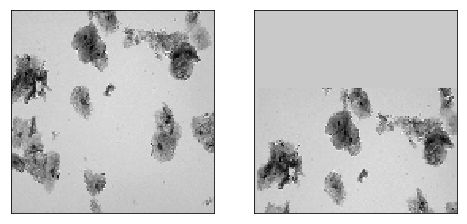

In [28]:
min_patch_size = 512
max_patch_size = 1024
patch = 128

fname = '../data/learning/Tp26_Y000_X001_040.tif'
im = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
im = cv2.resize(im, (1024,1024), interpolation=cv2.INTER_CUBIC)
a,b,h = create_multiscale_rigid_patches(im, min_patch_size, max_patch_size, \
                                        (patch,patch), 0.5)

fig, (ref, mov) = plt.subplots(1, 2, figsize=(8, 4))
print(h)
ref.imshow(a, cmap='gray')
ref.get_xaxis().set_visible(False)
ref.get_yaxis().set_visible(False)

mov.imshow(b, cmap='gray')
mov.get_xaxis().set_visible(False)
mov.get_yaxis().set_visible(False)

plt.show()

In [31]:
all_files[-5:]

['../data/learning\\Tp26_Y005_X001_040.tif',
 '../data/learning\\Tp26_Y003_X008_040.tif',
 '../data/learning\\Tp26_Y002_X008_040.tif',
 '../data/learning\\Tp26_Y005_X008_040.tif',
 '../data/learning\\Tp26_Y003_X002_040.tif']

In [42]:
df = pd.DataFrame(columns=['fname', 'h'])
min_patch_size = 512
max_patch_size = 1024
overlap = 0.5

output_size = (128, 128)
ratio = output_size[0] / patch_size

'''
we have 8*15 = 120 images right now...
100 = 1200
500 = 60,000
750 = 90,000
1000 = 120,000
4167 = 500,040
'''

output_dir = '../data/hnet_multiscale_training_128_holdout_%s' % datetime.date.today().isoformat()
try: 
    mkdir(output_dir)
except FileExistsError:
    output_dir += str(np.randint(0,1000))
    print('directory already exists, creating %s' % output_dir)
    mkdir(output_dir)

holdout = -6 # 5% 
    
patches_per_image = 500

for f in all_files[:holdout]:
    fname,ext = os.path.basename(f).split('.')
    im = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    im = cv2.resize(im, (1024,1024), interpolation=cv2.INTER_CUBIC) # aspect ratio destruction.
    for p in range(0, patches_per_image):
        A,B,Hab = create_multiscale_rigid_patches(im, min_patch_size, max_patch_size, \
                                                  output_size, overlap)
        fbase = '%s_%s' % (fname, str(p).rjust(4, '0'))
        A_name = '%s_A.%s' % (fbase, ext)
        B_name = '%s_B.%s' % (fbase, ext)
        cv2.imwrite(os.path.join(output_dir, A_name), cv2.resize(A, output_size, interpolation=cv2.INTER_NEAREST))
        cv2.imwrite(os.path.join(output_dir, B_name), cv2.resize(B, output_size, interpolation=cv2.INTER_NEAREST))
        hab_1d = ','.join(list(map(lambda x: '%0.03f' % float(x), Hab)))
        df = df.append({'fname':fbase, 'h':hab_1d}, ignore_index=True)

df.to_csv(os.path.join(output_dir, 'homographies.tsv'),sep='\t')

In [45]:
from shutil import copyfile

test = output_dir + '/holdout'
try: 
    mkdir(test)
    for f in all_files[holdout:]:
        copyfile(f, os.path.join(test, os.path.basename(f)))
except FileExistsError:
    print('directory and files already exists')

In [46]:
df.head()

,fname,h
0,Tp26_Y003_X006_040_0000,"0.159,-0.315"
1,Tp26_Y003_X006_040_0001,"-0.345,-0.196"
2,Tp26_Y003_X006_040_0002,"0.145,-0.262"
3,Tp26_Y003_X006_040_0003,"-0.254,-0.237"
4,Tp26_Y003_X006_040_0004,"-0.025,-0.356"


## rigid - 4pt homography

In [4]:
from math import cos, sin, pi
from numpy.random import randint

def alter_pt_rigid(pt, r, c, th):
    '''
    given a point, rho, a center, and a theta range; transform the point randomly
    '''
    rx,ry = r
    cos_t = cos(th)
    sin_t = sin(th)
    nx,ny = pt
    cx,cy = c
    # rotate around c
    tx = nx - cx
    ty = ny - cy
    nx = (tx * cos_t - ty * sin_t) + cx
    ny = (ty * cos_t + tx * sin_t) + cy
    # translate
    return (nx+rx, ny+ry)

def create_4pt_rigid_patches(im, size, r, min_th, max_th, final_size):
    '''
    Create pairs of patches from an image
    '''
    while True:
        # generate four random points, r to size-r so as to not go over the edge
        x = randint(2*r, im.shape[0]-size-2*r)
        y = randint(2*r, im.shape[1]-size-2*r)
        tl = (x,y)
        tr = (tl[0]+size, tl[1])
        br = (tl[0]+size, tl[1]+size)
        bl = (tl[0], tl[1]+size)
        A = im[y:y+size,x:x+size] # this is our 'reference' image
        # alter points randomly by rho
        const_r = randint(-r,r+1,2)
        const_th = randint(min_th, max_th+1) * pi/180
        tl2 = alter_pt_rigid(tl, const_r, (x + size//2, y + size//2), const_th)
        tr2 = alter_pt_rigid(tr, const_r, (x + size//2, y + size//2), const_th)
        br2 = alter_pt_rigid(br, const_r, (x + size//2, y + size//2), const_th)
        bl2 = alter_pt_rigid(bl, const_r, (x + size//2, y + size//2), const_th)
        perturbed = np.float32([tl2, tr2, br2, bl2])
        # transform
        H = cv2.getPerspectiveTransform(np.float32([tl, tr, br, bl]), perturbed)
        Hab = np.linalg.inv(H) 
        # warp image
        full_warped = cv2.warpAffine(im, Hab[:2,:], im.shape, flags=cv2.INTER_CUBIC, \
                                          borderMode=cv2.BORDER_CONSTANT, borderValue=int(im.mean()))
        B = full_warped[y:y+size,x:x+size]
        
        # make sure the images actually have contents.
        thresh = .02 * A.size
        _, binary_a = cv2.threshold(A,127,1,cv2.THRESH_BINARY_INV)
        _, binary_b = cv2.threshold(B,127,1,cv2.THRESH_BINARY_INV)
        if A.shape == B.shape and binary_a.sum() > thresh and binary_b.sum() > thresh:
            A = cv2.resize(A, final_size, interpolation=cv2.INTER_CUBIC)
            B = cv2.resize(B, final_size, interpolation=cv2.INTER_CUBIC)
            return A, B, np.subtract(perturbed, [tl, tr, br, bl])


../data/learning/Tp26_Y001_X003_040.tif (2048, 2368) 768 256
[[-393.08307648  470.23498535]
 [-564.23498535  -13.08306885]
 [ -80.91687012 -184.23498535]
 [  90.23498535  299.08312988]]


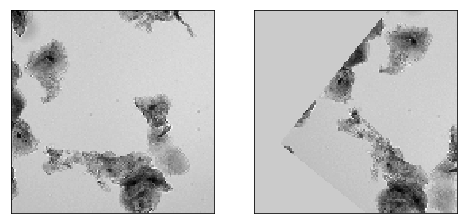

In [16]:
patch_size = 768
rho = 256 # 1/3rd

fname = '../data/learning/Tp26_Y001_X003_040.tif'
im = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
im = np.pad(im, int(2*rho), mode='constant', constant_values=np.median(im))
print(fname, im.shape, patch_size, rho)
a,b,h = create_4pt_rigid_patches(im, patch_size, rho, -45,45, (128,128))

fig, (ref, mov) = plt.subplots(1, 2, figsize=(8, 4))
print(h)
ref.imshow(a, cmap='gray')
ref.get_xaxis().set_visible(False)
ref.get_yaxis().set_visible(False)

mov.imshow(b, cmap='gray')
mov.get_xaxis().set_visible(False)
mov.get_yaxis().set_visible(False)

plt.show()

In [18]:
df = pd.DataFrame(columns=['fname', 'h'])
patch_size = 512
rho = 256

output_size = (128,128)
ratio = output_size[0] / patch_size

'''
we have 8*15 = 120 images right now...
100 = 1200
500 = 60,000
750 = 90,000
1000 = 120,000
4167 = 500,040
'''
output_dir = '../data/hnet_rotation_training_128_holdout_%s' % datetime.date.today().isoformat()

try: 
    mkdir(output_dir)
except FileExistsError:
    output_dir += str(randint(0,1000))
    print('directory already exists, creating %s' % output_dir)
    mkdir(output_dir)

holdout = -6 # 5% 

patches_per_image = 500

for f in all_files[:holdout]:
    fname,ext = os.path.basename(f).split('.')
    im = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    im = cv2.resize(im, (1024,1024), interpolation=cv2.INTER_CUBIC) # aspect ratio destruction.
    im = np.pad(im, int(2*rho), mode='constant', constant_values=np.median(im))
    for p in range(0, patches_per_image):
        A,B,Hab = create_4pt_rigid_patches(im, patch_size, rho, -45,45, output_size)
        fbase = '%s_%s' % (fname, str(p).rjust(4, '0'))
        A_name = '%s_A.%s' % (fbase, ext)
        B_name = '%s_B.%s' % (fbase, ext)
        cv2.imwrite(os.path.join(output_dir, A_name), A)
        cv2.imwrite(os.path.join(output_dir, B_name), B)
        mod_Hab = Hab * ratio
        hab_1d = ','.join(list(map(lambda x: '%0.04f' % float(x), mod_Hab.reshape(1,8)[0].tolist())))
        df = df.append({'fname':fbase, 'h':hab_1d}, ignore_index=True)

df.to_csv(os.path.join(output_dir, 'homographies.tsv'),sep='\t')

In [19]:
from shutil import copyfile

test = output_dir + '/holdout'
try: 
    mkdir(test)
    for f in all_files[holdout:]:
        copyfile(f, os.path.join(test, os.path.basename(f)))
except FileExistsError:
    print('directory and files already exists')

In [20]:
df.head()

,fname,h
0,Tp26_Y003_X006_040_0000,"80.0392,-64.5138,51.5139,16.0392,-29.0392,-12...."
1,Tp26_Y003_X006_040_0001,"18.4882,-7.5628,18.3128,-14.2618,25.0118,-14.4..."
2,Tp26_Y003_X006_040_0002,"38.2204,14.9990,30.5010,-28.7796,74.2796,-36.4..."
3,Tp26_Y003_X006_040_0003,"-19.6072,13.6267,-19.6267,11.3928,-17.3928,11...."
4,Tp26_Y003_X006_040_0004,"-6.1346,86.0332,-29.2832,12.6154,44.1346,-10.5..."
